In [69]:
%env CUDA_VISIBLE_DEVICES= 3,5,7


env: CUDA_VISIBLE_DEVICES=3,5,7


In [70]:
import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'

## IndicTrans2

In [71]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)

cuda


In [72]:
import transformers
print(transformers.__version__)

4.44.2


In [73]:
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)

pir= poss_indic_rel.possible_relations
pir

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings

In [74]:
# span_encodings['ory_Orya']

In [75]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model

In [76]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir,  quantization)

ip_en_ind = IndicProcessor(inference=True)

# Util Functions

In [77]:


def resolve_logits_for_best_beam(outputs, num_beams):
    """ Resolve the logits from the best beam, using model output from a generate call.
        For a shape [tokens?, batch_size*num_beams, vocab], returns [tokens?, batch_size, vocab]

        Assumes num_return_sequences=1."""

    print("length of output beam", len(outputs.beam_indices))
    print("shape of beam_indices", outputs.beam_indices.shape)
    print("shape of logits", (outputs.logits[0].shape))
    print("length of logits", len(outputs.logits))
    print("length od outputs", len(outputs))
    best_logits  = []
    beam_indices = [outputs.beam_indices[:, i].tolist() for i in range(len(outputs.logits)) if i < outputs.beam_indices.shape[1]]  
    print("length of beam_indices", len(beam_indices))

    for beam_index, logits in zip(beam_indices, outputs.logits):
        beam_index = [ idx if idx != -1 else ((num_beams*(i+1))-1) for i, idx in enumerate(beam_index) ]
        best_logits.append(logits[beam_index,:])

    return best_logits




def get_logits_for_span(logits, translations, tokenizer, search_spans, span_encodings, lang):
    """ Given search spans, returns the logits before the span was generated.

    Args:
        logits (tuple[Tensor]): Tuple of tensors, of shape [tokens?, batch_size, vocab]
        sequences (tuple[list[int]]): Tokenized output sequences.
        tokenizer (PreTrainedTokenizerBase): Tokenizer for the model.
        search_spans (list[str]): batch_size spans to search for. Must be present in the generated sequences.

    Returns:
        Tensor: Tensor of shape [batch_size, vocab] indicating the logits before the span for each batch element.
    """
    if isinstance(search_spans, str):
        search_spans = [ search_spans ] * len(translations)

    # with tokenizer.as_target_tokenizer():   
    #     detok_outputs = tokenizer.batch_decode(translations, skip_special_tokens=True)

    # positions = [ output.index(span) for output, span in zip(translations, search_spans) ]
    logit_pos = [  ]

    for seq,  span,  in zip(translations,  search_spans): 
        # print("Span to search for:", span, span_encodings[lang])
        key = next((k for k in span_encodings[lang].keys() if span in k), "None")
        subtokens = span_encodings[lang][key]
        print("subtokens", subtokens)
        print("for span:", span, "subtokens", subtokens)
        print("seq", seq)
        idx = 0
        while idx < len(seq)-1:
            if any( idx+i < len(seq) and seq[idx+i] == tok for i, tok in enumerate(subtokens)): 
                # print( "found", idx)
                break
            idx += 1
        logit_pos.append(idx-1)
    
    print("logit_pos", logit_pos)
    print("Dimensions of logits", logits[0].shape, len(logits))

    selected_logits = []
    # Iterate over each batch and corresponding token position
    for batch, token in enumerate(logit_pos):
        print("batch, token", batch, token)
        print("len(logits)", len(logits))
        print("Shape of logits", logits[0].shape)
        # print("logits token", logits[token])
        print("logits 1st item 1st row",logits[0][0])
        # Extract logits for the specific token position in the current batch
        current_logit = logits[token][batch, :]
        # current_logit = logits[token][0]
        
        # Append the selected logit to the list
        selected_logits.append(current_logit)

    # Stack the list of selected logits into a tensor
    selected_logits = torch.stack(selected_logits)

    return selected_logits
        
    # return selected_logits
    # return torch.stack([ logits[token][batch,:] for batch, token in enumerate(logit_pos) ])


In [78]:
def get_search_spans(inp_sents, tgt_lang, translations):
    search_spans= []
    root_amb_words=[]
    # print("inp_sents", inp_sents)
    for idx, inp in enumerate(inp_sents):
        # check which word from ambiguos_Wwords in present in the input sentence
        for word in ambiguos_words:
            if word in inp:
                curr_amb_word= word
        root_amb_words.append(curr_amb_word)

        # get the possible relations for the current ambiguous word
        possible_relations= pir[curr_amb_word][tgt_lang].keys()
        # print("Possible relations for the word", curr_amb_word, "in", tgt_lang, "are", possible_relations)

        # find the word in the translation from the possible relations. if not found print the translation
        for rel in possible_relations:
            if rel in translations[idx]:
                # print("Relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx], "at ", translations[idx].index(rel), "\nso sentece is", translations[idx][translations[idx].index(rel):])
                search_spans.append(rel)
                break
        else:
            # print("No relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx])
            search_spans.append(translations[idx][0])
    # print("Search spans are", search_spans)
    return root_amb_words, search_spans
       



In [79]:



def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, span_encodings):
    translations = []
    start_logits = []
    root_amb_words = []
    searched_spans = []
    for i in tqdm(range(0, len(input_sentences), BATCH_SIZE)):
        batch = input_sentences[i : i + BATCH_SIZE]
        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)
        with torch.no_grad():
            # generated_tokens = model.generate(
            outputs = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1, # TODO temp
                output_scores=True,
                output_logits=True,
                return_dict_in_generate=True,

            )
            print("Length of outputs.logits actual", len(outputs.logits))
            print("Shape of outputs.logits actual", outputs.logits[0].shape)

            print("Length of outputs.beam_indices actual", len(outputs.beam_indices))
            print("Shape of outputs.beam_indices actual", outputs.beam_indices.shape)
            print("*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?**********", outputs.beam_indices.shape[1] == len(outputs.logits))
            
            outputs.beam_indices = outputs.beam_indices.cpu()
            outputs.logits = tuple(logits.cpu() for logits in outputs.logits)               
        # Decode the generated tokens into text
        generated_tokens = outputs.sequences
        # print("len generated_tokens: ", (generated_tokens[0]).shape)
        # print("1st generated token: ", generated_tokens[0])
        vector = generated_tokens.detach().cpu().tolist()
        # print("length of outputs vectors: ", len(vector), len(vector[0]))
        # print("vector of generated_tokens: ", vector)
        # print("1st vector: ", vector[0])



        with tokenizer.as_target_tokenizer():
            decoded_op = tokenizer.batch_decode(
                vector,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # print("1st decoded_op: ", decoded_op[0])
        # Postprocess the translations, including entity replacement
        transl = ip.postprocess_batch(decoded_op, lang=tgt_lang)

        # print("translations: ", transl)
        

        root_words, search_spans = get_search_spans(batch,  tgt_lang, transl)
        searched_spans += search_spans
        root_amb_words += root_words
        # print("length search_spans: ", len(search_spans))
        best_logits = resolve_logits_for_best_beam(outputs, num_beams=5)
        # print("length best_logits: ",len(best_logits))
        # print("length of best_logits: ", len(best_logits), (best_logits[0]).shape)

        start_logits += get_logits_for_span(best_logits, outputs.sequences, tokenizer, search_spans, span_encodings, tgt_lang)
        # start_logits += get_logits_for_span(best_logits, translations, tokenizer, search_spans)
        translations += transl
        del inputs
        torch.cuda.empty_cache()

    return translations, start_logits, root_amb_words, searched_spans

In [80]:
lang_script_list = [
     'tel_Telu',
                           'ory_Orya',
                     'pan_Guru', 'ben_Beng', 
                       'mal_Mlym',
                           'mar_Deva', 
                           'tam_Taml', 
                           'guj_Gujr', 
                          
                             'hin_Deva', 
                           'kan_Knda', 
                           ]

In [81]:
test_csv_folder = 'custom_test_csv'

In [82]:
lang_code_map = {
    'eng_Latn': 'en',
    'hin_Deva': 'hi',
    'guj_Gujr': 'gu',
    'kan_Knda': 'kn',
    'mal_Mlym': 'ml',
    'mar_Deva': 'mr',
    'tam_Taml': 'ta',
    'tel_Telu': 'te',
    'pan_Guru': 'pa',
    'ben_Beng': 'bn',
    'ory_Orya': 'or'
}


In [83]:
sents = []
with open('test_sentences_eng.txt', 'r') as f:
    sents = f.readlines()
sents = [sent.strip() for sent in sents if sent.find('child')==-1]
print(len(sents))

1809


In [84]:
SAMPLE_SIZE = 10
# SAMPLE_SIZE = len(sents)
sents = sents[:SAMPLE_SIZE]
# sents

# Execute Translations

In [85]:
src_lang = "eng_Latn"
output_trnsl={}
output_logits={}

for lang in lang_script_list:
    tgt_lang = lang
    print(lang)
    # if tgt_lang != 'ory_Orya':
    #     continue
    translations, logits, root_amb_words, searched_spans = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind, span_encodings)
    output_trnsl[lang] = translations
    output_logits[lang] = logits

    # # save hindi translations to a file test_translations_hin.txt
    # with open('test_translations/indic_trans2/test_transl_it2_'+lang+'.txt', 'w') as f:
    #     for sent in translations:
    #         f.write(sent + '\n')

    # save the logits to a file 
    # with open('test_trasnlations/indic_trans2/test_transl_it2_'+lang+'_logits.txt', 'w') as f:
    #     for logit in logits:
    #         f.write(str(logit) + '\n')

tel_Telu


 33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,   354,  1774,  1476, 56061,  3494,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 14552,   151, 56061,  3494,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: మ subtokens [1774, 1476]
seq tensor([    2,   354, 30539, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
subtokens [11569, 20269]
for span: అత్త subtokens [11569, 20269]
seq tensor(

 67%|██████▋   | 2/3 [00:01<00:00,  1.82it/s]

Length of outputs.logits actual 12
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 10])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 10])
shape of logits torch.Size([20, 122672])
length of logits 12
length od outputs 6
length of beam_indices 10
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46, 19360, 56061,  3494,   728,     4,     2,     1,     1],
       device='cuda:0')
subtokens [76, 2621, 20269]
for span: వదిన subtokens [76, 2621, 20269]
seq tensor([    2,    46,    76,  2621, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 471, 4645]
for span: న subtokens [14581, 471, 4645]
seq tensor([    2,    46,  2922,  3432, 56061,  3494,   728,     4,     2,     1],
       device='cuda:0')
subtokens [14581, 4

100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Length of outputs.logits actual 11
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 10])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 2
shape of beam_indices torch.Size([2, 10])
shape of logits torch.Size([10, 122672])
length of logits 11
length od outputs 6
length of beam_indices 10
subtokens [14581, 307, 12563]
for span: మేనకోడలు subtokens [14581, 307, 12563]
seq tensor([    2,    46, 14581,   307, 12563, 56061,  3494,   728,     4,     2],
       device='cuda:0')
subtokens [1774, 1476]
for span: అమ్మమ subtokens [1774, 1476]
seq tensor([    2,    46,  1774,  1476, 64275, 20903,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 10
batch, token 0 1
len(logits) 10
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-1.0410, -1.0410,  0.5488, 

 33%|███▎      | 1/3 [00:00<00:00,  2.40it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [41445, 241, 30]
for span: ଜେଜେମା subtokens [41445, 241, 30]
seq tensor([    2,   644, 41445,   241,  4725, 28125,     6,     2,     1],
       device='cuda:0')
subtokens [41445, 1007, 1714]
for span: ଜେଜେବାପା subtokens [41445, 1007, 1714]
seq tensor([    2,   644, 41445,  1007,  1714,  4725, 28125,     6,     2],
       device='cuda:0')
subtokens [9971, 19212, 6]
for span: ମାମୁଁ subtokens [9971, 19212, 6]
seq tensor([    2,   644,  9971, 19212,  4725, 28125,     6,     2,     1],
       device='cuda:0')
subtokens [30261, 694, 6]
for span

 67%|██████▋   | 2/3 [00:00<00:00,  2.48it/s]

Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 9
subtokens [5442, 1754, 89]
for span: ଭିଣୋଇ subtokens [5442, 1754, 89]
seq tensor([    2,   644,  5442,  1754,    89,  4725, 28125,     6,     2],
       device='cuda:0')
subtokens [4569, 25547]
for span: ଭାଉଜ subtokens [4569, 25547]
seq tensor([    2,   644,  4569, 25547,  4725, 28125,     6,     2,     1],
       device='cuda:0')
subtokens [60824, 3991, 6]
for span: ଭାଇ subtokens [60824, 3991, 6]
seq tensor([    2,  4433, 60824,  3991,  4725, 28125,     6,     2,     1],
       device='cuda:0')
subtokens [4300, 5686]
for span: ପୁତୁରା subtokens [4300,

100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [980, 9742, 795]
for span: ଭାଣିଜୀ subtokens [980, 9742, 795]
seq tensor([    2,  4433,   980,  9742,   795,  4725, 28125,     6,     2],
       device='cuda:0')
subtokens [41445, 241, 30]
for span: ଜେଜେମା subtokens [41445, 241, 30]
seq tensor([    2,   644, 41445,   241,  4725, 65121,  2383,     6,     2],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.6582, -0.6582,  0.9565,  ..., -0.6587, -0.

 33%|███▎      | 1/3 [00:00<00:00,  2.01it/s]

Length of outputs.logits actual 12
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 11])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 11])
shape of logits torch.Size([20, 122672])
length of logits 12
length od outputs 6
length of beam_indices 11
subtokens [29498, 640]
for span: ਦਾਦੀ subtokens [29498, 640]
seq tensor([    2,  1653, 29498,    88,    19,    75, 61699, 10002,     8,     6,
            2], device='cuda:0')
subtokens [15588, 613]
for span: ਦਾਦਾ subtokens [15588, 613]
seq tensor([    2,   790, 15588,    88,    19,    75, 61699, 10002,   180,     6,
            2], device='cuda:0')
subtokens [34059]
for span: ਚਾਚਾ subtokens [34059]
seq tensor([    2,   790, 34059,    88,    19,    75, 61699, 10002,   180,     6,
            2], device='cuda:0')
subtokens [65770, 613, 6]
for spa

 67%|██████▋   | 2/3 [00:01<00:00,  1.88it/s]

Length of outputs.logits actual 13
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 13])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 13])
shape of logits torch.Size([20, 122672])
length of logits 13
length od outputs 6
length of beam_indices 13
subtokens [613, 2935]
for span: ਜੀਜਾ subtokens [613, 2935]
seq tensor([    2,  2243,   613,  2935,    88,    19,    75, 61699, 10002,     8,
            6,     2,     1], device='cuda:0')
subtokens [29498, 640]
for span: ਮ subtokens [29498, 640]
seq tensor([    2,  1653,  1144, 40842,    88,    19,    75, 61699, 10002,     8,
            6,     2,     1], device='cuda:0')
subtokens [29498, 640]
for span: ਮ subtokens [29498, 640]
seq tensor([    2,  2243, 49615,  2656,  8327,    88,    19,    75, 61699, 10002,
            8,     6,     2], device=

100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Length of outputs.logits actual 13
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 12])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 2
shape of beam_indices torch.Size([2, 12])
shape of logits torch.Size([10, 122672])
length of logits 13
length od outputs 6
length of beam_indices 12
subtokens [39136, 795]
for span: ਭਤੀਜੀ subtokens [39136, 795]
seq tensor([    2,  1653, 39136,   795,    88,    19,    75, 61699, 10002,     8,
            6,     2], device='cuda:0')
subtokens [29498, 640]
for span: ਦਾਦੀ subtokens [29498, 640]
seq tensor([    2,  1653, 29498,    88,    19,    75,  1052,    19,  1304,     8,
            6,     2], device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 12
batch, token 0 1
len(logits) 12
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4460, -0.445

 33%|███▎      | 1/3 [00:00<00:00,  2.97it/s]

Length of outputs.logits actual 8
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 8])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 8])
shape of logits torch.Size([20, 122672])
length of logits 8
length od outputs 6
length of beam_indices 8
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181, 58599,   241,  1279, 28125,     6,     2],
       device='cuda:0')
subtokens [409, 8599]
for span: দাদু subtokens [409, 8599]
seq tensor([    2,   181,   409,  8599,  1279, 28125,     6,     2],
       device='cuda:0')
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181, 41565,  1279, 28125,     6,     2,     1],
       device='cuda:0')
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181, 57511, 

 67%|██████▋   | 2/3 [00:00<00:00,  2.54it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181,   649,  4692,    75,  1279, 28125,     6,     2],
       device='cuda:0')
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181,   649,  4692,  1525,  1279, 28125,     6,     2],
       device='cuda:0')
subtokens [35407, 359, 3991, 6]
for span: ভাই subtokens [35407, 359, 3991, 6]
seq tensor([    2,   181, 35407,   359,  3991,  1279, 28125,     6,     2],
       device='cuda:0')
subtokens [5745, 102, 6]
for span: আ subtokens [5745

100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 9
length od outputs 6
length of beam_indices 9
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181,   291, 17389,  1279, 28125,     6,     2,     1],
       device='cuda:0')
subtokens [5745, 102, 6]
for span: আ subtokens [5745, 102, 6]
seq tensor([    2,   181, 58599,   241,  1279, 65121,  2383,     6,     2],
       device='cuda:0')
logit_pos [3, 4]
Dimensions of logits torch.Size([2, 122672]) 9
batch, token 0 3
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.6128, -0.6123,  1.7666,  ..., -0.6128, -0.6123, -0.6123],
     

 33%|███▎      | 1/3 [00:00<00:00,  2.04it/s]

Length of outputs.logits actual 12
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 12])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 12])
shape of logits torch.Size([20, 122672])
length of logits 12
length od outputs 6
length of beam_indices 12
subtokens [2]
for span: എ subtokens [2]
seq tensor([    2,   223,    28, 14392, 18823,  2914,  2826,    50, 28125,  1844,
            4,     2], device='cuda:0')
subtokens [2]
for span: എ subtokens [2]
seq tensor([    2,  1216, 18823,  5136,    28,    50, 28125,  2963,     4,     2,
            1,     1], device='cuda:0')
subtokens [1774, 529, 28]
for span: അമ്മാവൻ subtokens [1774, 529, 28]
seq tensor([    2,  1216,  1774,   529,    28,    50, 28125,  2963,     4,     2,
            1,     1], device='cuda:0')
subtokens [2]
for span: എ subtokens 

 67%|██████▋   | 2/3 [00:01<00:00,  1.82it/s]

Length of outputs.logits actual 14
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 14])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 14])
shape of logits torch.Size([20, 122672])
length of logits 14
length od outputs 6
length of beam_indices 14
subtokens [2]
for span: എ subtokens [2]
seq tensor([    2,   223,    28, 14392,  3954,  4109,  3426,   877,    28,    50,
        28125,  2963,     4,     2], device='cuda:0')
subtokens [2]
for span: എ subtokens [2]
seq tensor([    2,   223,    28, 14392,  3954,  4109,  3426, 50084,    50, 28125,
         1844,     4,     2,     1], device='cuda:0')
subtokens [2]
for span: എ subtokens [2]
seq tensor([    2,   223,    28,  1017, 43494,    28,    50, 28125,  2963,     4,
            2,     1,     1,     1], device='cuda:0')
subtokens [1326, 13315, 

100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Length of outputs.logits actual 13
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 13])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 2
shape of beam_indices torch.Size([2, 13])
shape of logits torch.Size([10, 122672])
length of logits 13
length od outputs 6
length of beam_indices 13
subtokens [1326, 13315, 128, 27]
for span: അനന്തരവൾ subtokens [1326, 13315, 128, 27]
seq tensor([    2,   223,    28, 14392,  1326, 13315,   128,    27,    50, 28125,
         1844,     4,     2], device='cuda:0')
subtokens [2]
for span: എ subtokens [2]
seq tensor([    2,   223,    28,  1017, 18823,  2914,  2826,    50, 64275,  1844,
            4,     2,     1], device='cuda:0')
logit_pos [3, -1]
Dimensions of logits torch.Size([2, 122672]) 13
batch, token 0 3
len(logits) 13
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor(

 33%|███▎      | 1/3 [00:00<00:00,  2.66it/s]

Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 8])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 8])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
subtokens [32967]
for span: आजी subtokens [32967]
seq tensor([    2,  6457, 32967, 28125,    38,     4,     2,     1],
       device='cuda:0')
subtokens [56799, 4]
for span: आजोबा subtokens [56799, 4]
seq tensor([    2,  2953, 56799, 28125,   233,     4,     2,     1],
       device='cuda:0')
subtokens [41565, 4]
for span: काका subtokens [41565, 4]
seq tensor([    2,  2953, 41565, 28125,   233,     4,     2,     1],
       device='cuda:0')
subtokens [11701, 987, 4]
for span: मावशी subtokens [11701, 987, 4]
seq tensor([    2,  6457, 11701,   987, 2812

 67%|██████▋   | 2/3 [00:00<00:00,  2.34it/s]

Length of outputs.logits actual 11
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 11
length od outputs 6
length of beam_indices 9
subtokens [530, 7131, 1067]
for span: मेहुणा subtokens [530, 7131, 1067]
seq tensor([    2,  6010,   530,  7131,  1067, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [530, 7131, 1730]
for span: मेहुणी subtokens [530, 7131, 1730]
seq tensor([    2,  6457,   530,  7131,  1730, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [6702, 119, 22699]
for span: चुलत भाऊ subtokens [6702, 119, 22699]
seq tensor([    2,  6010,  6702,   119, 22699, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [11701, 987, 4]
for s

100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 8])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 2
shape of beam_indices torch.Size([2, 8])
shape of logits torch.Size([10, 122672])
length of logits 9
length od outputs 6
length of beam_indices 8
subtokens [4569, 362]
for span: भाची subtokens [4569, 362]
seq tensor([    2,  6457,  4569,   362, 28125,    38,     4,     2],
       device='cuda:0')
subtokens [32967]
for span: आजी subtokens [32967]
seq tensor([    2,  6457, 32967, 64275,    38,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 8
batch, token 0 1
len(logits) 8
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4478, -0.4480,  1.1982,  ..., -0.4480, -0.4480, -0.4478],
       dtype=torch.float16)
batch

 33%|███▎      | 1/3 [00:00<00:00,  2.37it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 10])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 10])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 10
subtokens [511, 956]
for span: பாட்டி subtokens [511, 956]
seq tensor([    2,  1214,   511,   956,    50,  1862, 25942,   131,     4,     2],
       device='cuda:0')
subtokens [14552, 3286, 4]
for span: தாத்தா subtokens [14552, 3286, 4]
seq tensor([    2,  1214, 14552,  3286,    50,  1862, 25942,   131,     4,     2],
       device='cuda:0')
subtokens [24501]
for span: மாமா subtokens [24501]
seq tensor([    2,  1214, 24501,    50,  1862, 25942,   131,     4,     2,     1],
       device='cuda:0')
subtokens [213, 681]
for span: அத்தை subtokens [21

 67%|██████▋   | 2/3 [00:00<00:00,  2.20it/s]

Length of outputs.logits actual 11
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 11])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 11])
shape of logits torch.Size([20, 122672])
length of logits 11
length od outputs 6
length of beam_indices 11
subtokens [1364, 864, 1488]
for span: மைத்துனர் subtokens [1364, 864, 1488]
seq tensor([    2,  1214,  1364,   864,  1488,    50,  1862, 25942,   131,     4,
            2], device='cuda:0')
subtokens [2]
for span: எ subtokens [2]
seq tensor([    2,  1214,  1364,   864,  1488,    50,  1862, 25942,   131,     4,
            2], device='cuda:0')
subtokens [2]
for span: எ subtokens [2]
seq tensor([    2,  4476,  2901, 47743,    50,  1862, 25942,   131,     4,     2,
            1], device='cuda:0')
subtokens [2]
for span: எ subtokens [2]
seq tensor(

100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 10])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 2
shape of beam_indices torch.Size([2, 10])
shape of logits torch.Size([10, 122672])
length of logits 10
length od outputs 6
length of beam_indices 10
subtokens [2]
for span: எ subtokens [2]
seq tensor([    2,  1214, 45894,  1022,    50,  1862, 25942,   131,     4,     2],
       device='cuda:0')
subtokens [511, 956]
for span: பாட்டி subtokens [511, 956]
seq tensor([   2, 1214,  511,  956,   50, 5117, 6963, 4987,    4,    2],
       device='cuda:0')
logit_pos [-1, 1]
Dimensions of logits torch.Size([2, 122672]) 10
batch, token 0 -1
len(logits) 10
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4431, -0.4431,  0.8281,  ..., -0.4431, -0.4431, -0.4431],
       dtype=torc

 33%|███▎      | 1/3 [00:00<00:00,  2.93it/s]

Length of outputs.logits actual 8
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 7])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 7])
shape of logits torch.Size([20, 122672])
length of logits 8
length od outputs 6
length of beam_indices 7
subtokens [29498]
for span: દાદી subtokens [29498]
seq tensor([    2,  2562, 29498, 28125,    15,     4,     2], device='cuda:0')
subtokens [15588]
for span: દાદા subtokens [15588]
seq tensor([    2,  1551, 15588, 28125,    15,     4,     2], device='cuda:0')
subtokens [41565]
for span: કાકા subtokens [41565]
seq tensor([    2,  1551, 41565, 28125,    15,     4,     2], device='cuda:0')
subtokens [64851]
for span: કાકી subtokens [64851]
seq tensor([    2,  2562, 64851, 28125,    15,     4,     2], device='cuda:0')
logit_pos [1, 1, 1, 1]
Dimensions of

 67%|██████▋   | 2/3 [00:00<00:00,  2.53it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [1872, 2466]
for span: સાળો subtokens [1872, 2466]
seq tensor([    2, 11788,  1872,  2466, 28125,    15,     4,     2,     1],
       device='cuda:0')
subtokens [1872, 2651]
for span: સાળી subtokens [1872, 2651]
seq tensor([    2,  2562,  1872,  2651, 28125,    15,     4,     2,     1],
       device='cuda:0')
subtokens [24501]
for span: મ subtokens [24501]
seq tensor([    2, 11788,  6042, 18974,  3991, 28125,    15,     4,     2],
       device='cuda:0')
subtokens [980, 14910, 3204]
for span: ભત્રીજો subtokens [980, 14910, 3204]
seq tens

100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Length of outputs.logits actual 11
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 11
length od outputs 6
length of beam_indices 9
subtokens [980, 14910, 795]
for span: ભત્રીજી subtokens [980, 14910, 795]
seq tensor([    2,  2562,   980, 14910,   795, 28125,    15,     4,     2],
       device='cuda:0')
subtokens [29498]
for span: દાદી subtokens [29498]
seq tensor([    2,  2562, 29498, 64275,    15,     4,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.4136, -0.4136,  1.0811,  ..., -0.4136, -0.4136, -0.4133],
 

 33%|███▎      | 1/3 [00:00<00:00,  2.65it/s]

Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 7])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 7])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 7
subtokens [29498, 12075]
for span: दादी subtokens [29498, 12075]
seq tensor([    2,  1653, 29498, 28125,    33,     6,     2], device='cuda:0')
subtokens [15588, 613, 6]
for span: दादा subtokens [15588, 613, 6]
seq tensor([    2,   790, 15588, 28125,    33,     6,     2], device='cuda:0')
subtokens [34059]
for span: चाचा subtokens [34059]
seq tensor([    2,   790, 34059, 28125,    33,     6,     2], device='cuda:0')
subtokens [60684]
for span: चाची subtokens [60684]
seq tensor([    2,  1653, 60684, 28125,    33,     6,     2], device='cuda:0')
logit_

 67%|██████▋   | 2/3 [00:00<00:00,  2.45it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [27985]
for span: साला subtokens [27985]
seq tensor([    2,  2243, 27985, 28125,     8,     6,     2,     1,     1],
       device='cuda:0')
subtokens [18477]
for span: साली subtokens [18477]
seq tensor([    2,  1653, 18477,    24, 28125,     8,     6,     2,     1],
       device='cuda:0')
subtokens [49615, 2656, 3057]
for span: भाई subtokens [49615, 2656, 3057]
seq tensor([    2,  2243, 49615,  2656,  3057, 28125,     8,     6,     2],
       device='cuda:0')
subtokens [69840]
for span: भतीजा subtokens [69840]
seq tensor([    2,  2243, 

100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 9
length od outputs 6
length of beam_indices 9
subtokens [39136, 795]
for span: भतीजी subtokens [39136, 795]
seq tensor([    2,  1653, 39136,   795,    24, 28125,     8,     6,     2],
       device='cuda:0')
subtokens [29498, 12075]
for span: दादी subtokens [29498, 12075]
seq tensor([    2,  1653, 29498, 64275,    33,     6,     2,     1,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.2267, -0.2268,  1.9307,  ..., -0.2269, -0.2268, -0.2268],
  

 33%|███▎      | 1/3 [00:00<00:00,  2.52it/s]

Length of outputs.logits actual 9
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** True
length of output beam 4
shape of beam_indices torch.Size([4, 9])
shape of logits torch.Size([20, 122672])
length of logits 9
length od outputs 6
length of beam_indices 9
subtokens [4565, 35330]
for span: ಅಜ್ಜಿ subtokens [4565, 35330]
seq tensor([    2,  1586,  4565, 35330, 28125,   194,     4,     2,     1],
       device='cuda:0')
subtokens [4565, 35330]
for span: ಅಜ್ಜ subtokens [4565, 35330]
seq tensor([    2,  1586, 44928,  3564, 28125,     4,     2,     1,     1],
       device='cuda:0')
subtokens [2950, 378]
for span: ಚಿಕ್ಕಪ್ಪ subtokens [2950, 378]
seq tensor([    2,  1586,  2950,   378,  3564, 28125,     4,     2,     1],
       device='cuda:0')
subtokens [2950, 1476, 4]
for span: ಚಿಕ್ಕಮ್ಮ subtokens [2950, 1476,

 67%|██████▋   | 2/3 [00:00<00:00,  2.15it/s]

Length of outputs.logits actual 12
Shape of outputs.logits actual torch.Size([20, 122672])
Length of outputs.beam_indices actual 4
Shape of outputs.beam_indices actual torch.Size([4, 10])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 4
shape of beam_indices torch.Size([4, 10])
shape of logits torch.Size([20, 122672])
length of logits 12
length od outputs 6
length of beam_indices 10
subtokens [1364, 58831]
for span: ನ subtokens [1364, 58831]
seq tensor([    2,  1586,  3373,   158,  3564, 28125,     4,     2,     1,     1],
       device='cuda:0')
subtokens [213, 24430]
for span: ಅತ್ತಿಗೆ subtokens [213, 24430]
seq tensor([    2,  1586,   213, 24430, 28125,  1384,     4,     2,     1,     1],
       device='cuda:0')
subtokens [1364, 58831]
for span: ನ subtokens [1364, 58831]
seq tensor([    2,  1586, 34385,  2182, 15841,  2603,  3564, 28125,     4,     2],
       device='cuda:0')
subtokens [1364, 58831]
for span: ನ subtokens 

100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

Length of outputs.logits actual 10
Shape of outputs.logits actual torch.Size([10, 122672])
Length of outputs.beam_indices actual 2
Shape of outputs.beam_indices actual torch.Size([2, 9])
*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?********** False
length of output beam 2
shape of beam_indices torch.Size([2, 9])
shape of logits torch.Size([10, 122672])
length of logits 10
length od outputs 6
length of beam_indices 9
subtokens [34385, 6324, 3658]
for span: ಸೋದರ ಸೊಸೆ subtokens [34385, 6324, 3658]
seq tensor([    2,  1586, 34385,  6324,  3658, 28125,  1384,     4,     2],
       device='cuda:0')
subtokens [4565, 35330]
for span: ಅಜ್ಜಿ subtokens [4565, 35330]
seq tensor([    2,  1586,  4565, 35330,  3564, 64275,     4,     2,     1],
       device='cuda:0')
logit_pos [1, 1]
Dimensions of logits torch.Size([2, 122672]) 9
batch, token 0 1
len(logits) 9
Shape of logits torch.Size([2, 122672])
logits 1st item 1st row tensor([-0.8945, -0.8940,  1.0840,  ..., -0.8940, -

In [86]:
# dataframe from the translations, logits and the root ambiguous words, searched spans
import pandas as pd

df = pd.DataFrame()
df['sentences'] = sents
df['root_ambiguous_words'] = root_amb_words
for lang in lang_script_list:
    # if lang != 'ory_Orya':
    #     continue
    # following 2 can be commented out to reduce the size of the dataframe
    df['searched_spans_'+lang] = searched_spans
    df['transl_'+lang_code_map[lang]] = output_trnsl[lang]
    df['logits_'+lang_code_map[lang]] = output_logits[lang]

df.head()

,sentences,root_ambiguous_words,searched_spans_tel_Telu,transl_te,logits_te,searched_spans_ory_Orya,transl_or,logits_or,searched_spans_pan_Guru,transl_pa,...,logits_ta,searched_spans_guj_Gujr,transl_gu,logits_gu,searched_spans_hin_Deva,transl_hi,logits_hi,searched_spans_kan_Knda,transl_kn,logits_kn
0,My grandmother is a Brahmin.,grandmother,ಅಜ್ಜಿ,మా అమ్మమ్మ బ్రాహ్మణుడు.,"[tensor(-1.6807, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,ମୋ ଜେଜେମା ଜଣେ ବ୍ରାହ୍ମଣ।,"[tensor(-1.5381, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,ਮੇਰੀ ਦਾਦੀ ਇੱਕ ਬ੍ਰਾਹਮਣ ਹੈ।,...,"[tensor(-0.7446, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,મારી દાદી બ્રાહ્મણ છે.,"[tensor(-0.7539, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,मेरी दादी ब्राह्मण हैं।,"[tensor(-0.7910, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,ನನ್ನ ಅಜ್ಜಿ ಬ್ರಾಹ್ಮಣರು.,"[tensor(-1.0566, dtype=torch.float16), tensor(..."
1,My grandfather is a Brahmin.,grandfather,ಅಜ್ಜ,మా తాత ఒక బ్రాహ్మణుడు.,"[tensor(0.0009, dtype=torch.float16), tensor(0...",ಅಜ್ಜ,ମୋ ଜେଜେବାପା ଜଣେ ବ୍ରାହ୍ମଣ।,"[tensor(-1.3369, dtype=torch.float16), tensor(...",ಅಜ್ಜ,ਮੇਰੇ ਦਾਦਾ ਇੱਕ ਬ੍ਰਾਹਮਣ ਹਨ।,...,"[tensor(-0.5171, dtype=torch.float16), tensor(...",ಅಜ್ಜ,મારા દાદા બ્રાહ્મણ છે.,"[tensor(-0.5103, dtype=torch.float16), tensor(...",ಅಜ್ಜ,मेरे दादा ब्राह्मण हैं।,"[tensor(-0.5205, dtype=torch.float16), tensor(...",ಅಜ್ಜ,ನನ್ನ ಅಜ್ಜ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.4062, dtype=torch.float16), tensor(..."
2,My uncle is a Brahmin.,uncle,ಚಿಕ್ಕಪ್ಪ,మా నాన్న బ్రాహ్మణుడు.,"[tensor(-0.7363, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,ମୋ ମାମୁଁ ଜଣେ ବ୍ରାହ୍ମଣ।,"[tensor(-1.5029, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,ਮੇਰੇ ਚਾਚਾ ਇੱਕ ਬ੍ਰਾਹਮਣ ਹਨ।,...,"[tensor(-0.9399, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,મારા કાકા બ્રાહ્મણ છે.,"[tensor(-0.9272, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,मेरे चाचा ब्राह्मण हैं।,"[tensor(-0.8447, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,ನನ್ನ ಚಿಕ್ಕಪ್ಪ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.1094, dtype=torch.float16), tensor(..."
3,My aunt is a Brahmin.,aunt,ಚಿಕ್ಕಮ್ಮ,నా అత్త బ్రాహ్మణుడు.,"[tensor(-1.6035, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,ମୋ ମାଉସୀ ଜଣେ ବ୍ରାହ୍ମଣ।,"[tensor(-1.9922, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,ਮੇਰੀ ਮਾਸੀ ਇੱਕ ਬ੍ਰਾਹਮਣ ਹੈ।,...,"[tensor(-1.0879, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,મારી કાકી બ્રાહ્મણ છે.,"[tensor(-1.6504, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,मेरी चाची ब्राह्मण हैं।,"[tensor(-1.4668, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,ನನ್ನ ಚಿಕ್ಕಮ್ಮ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣೆ.,"[tensor(-1.3389, dtype=torch.float16), tensor(..."
4,My brother-in-law is a Brahmin.,brother-in-law,ನ,నా బావ బ్రాహ్మణుడు.,"[tensor(-0.2654, dtype=torch.float16), tensor(...",ನ,ମୋ ଭିଣୋଇ ଜଣେ ବ୍ରାହ୍ମଣ।,"[tensor(-1.5986, dtype=torch.float16), tensor(...",ನ,ਮੇਰਾ ਜੀਜਾ ਇੱਕ ਬ੍ਰਾਹਮਣ ਹੈ।,...,"[tensor(-0.9644, dtype=torch.float16), tensor(...",ನ,મારો સાળો બ્રાહ્મણ છે.,"[tensor(-1.3604, dtype=torch.float16), tensor(...",ನ,मेरा साला ब्राह्मण है।,"[tensor(-0.8120, dtype=torch.float16), tensor(...",ನ,ನನ್ನ ಅಳಿಯ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(0.0098, dtype=torch.float16), tensor(0..."


In [87]:
# for all sentences:
#    for all langs:
#     for the given root ambiguous word, get the possible relations in the target language
#      group the possible relations into matriarchal and patriarchal
#       <*>find the logits for the words in matrirachi and patriachal relations
#       find the sum over respective sets and take difference of both sums
#       if difference is positive, then the wordXlang is matriarchal, else patriarchal
#     Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix


In [88]:
final_res={}

In [116]:
# for each row of dataframe with index i
for i in range(len(df)):
    # print("Index: ", i)
    for lang in lang_script_list:
        # if lang != 'ory_Orya':
        #     continue
        # print("Lang: ", lang)
        if final_res.get(lang, None) is None:
            final_res[lang] = {}
        root_amb_word = df.loc[i, 'root_ambiguous_words']
        # print("Root ambiguous word: ", root_amb_word)
        possible_relations = list(pir[root_amb_word][lang].keys())
        # print("Possible relations: ", possible_relations)
        matriarchal = []
        patriarchal = []
        for rel in possible_relations:
            if 'F' == pir[root_amb_word][lang][rel]['relation_code']:
                matriarchal.append(rel)
            if 'M' == pir[root_amb_word][lang][rel]['relation_code']:
                patriarchal.append(rel)
        # print("for lang: ", lang, "root amb word: ", root_amb_word, "matriarchal: ", matriarchal, "patriarchal: ", patriarchal)
        
        logits = df.loc[i, 'logits_'+lang_code_map[lang]]
        # print("Logits: ", logits)
        matriarchal_logits = []
        patriarchal_logits = []
        for relations in [matriarchal, patriarchal]:
            for rel in relations:
                # print("for reln:", rel, "span_encodings:", span_encodings[lang].get(rel, None))
                # if rel is present in any key of span_encodings[lang], then print its value
                key = next((k for k in span_encodings[lang].keys() if rel in k), "None")
                word_index = span_encodings[lang].get(key, None)
                # print("for reln::", rel, "Index::", word_index)
                
                # find the avg of the logits for the word_index
                if word_index is not None:
                    avg_logits = torch.mean(logits[word_index], dim=0)
                    # print("Avg logits: ", avg_logits)
                    if relations == matriarchal:
                        matriarchal_logits.append(avg_logits)
                    else:
                        patriarchal_logits.append(avg_logits)

        # print("Matriarchal sets: ", matriarchal_logits, "Patriarchal sets: ", patriarchal_logits)

        # combine arrays of matriarchal and patriarchal logits and find softmax over the new resultant array and separate the matriarchial and patriarchial logits
        if matriarchal_logits and patriarchal_logits:
            effective_logits = torch.stack(matriarchal_logits)
            effective_logits = torch.cat((effective_logits, torch.stack(patriarchal_logits)))
            effective_logits = softmax(effective_logits, dim=0)
            matriarchal_logits_softmax = effective_logits[:len(matriarchal_logits)]
            patriarchal_logits_softmax = effective_logits[len(matriarchal_logits):]

            diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax)) 
            # /tmp/ipykernel_1975081/1980739227.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
            print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff.item())
            # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")
            final_res[lang][root_amb_word] = diff.item()
        else:
            final_res[lang][root_amb_word] = 0
            print(f"Skipping word: {root_amb_word} in lang: {lang} due to empty logits.")



        # find the sum over respective sets and take difference of both sums
        # diff = torch.sum(torch.tensor(matriarchal_logits)) - torch.sum(torch.tensor(patriarchal_logits))
        # print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff)
        # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")

        # #Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix
        # final_matrix[root_amb_word][lang] = diff

        #     matriarchal_logits.append(logits[]
        # print("Matriarchal sets: ", matriarchal, "Patriarchal sets: ", patriarchal)




For word:  grandmother in lang:  tel_Telu Difference:  0.6171875
For word:  grandmother in lang:  ory_Orya Difference:  -0.9638671875
For word:  grandmother in lang:  pan_Guru Difference:  0.77734375
For word:  grandmother in lang:  ben_Beng Difference:  0.126220703125
Skipping word: grandmother in lang: mal_Mlym due to empty logits.
Skipping word: grandmother in lang: mar_Deva due to empty logits.
For word:  grandmother in lang:  tam_Taml Difference:  0.671875
For word:  grandmother in lang:  guj_Gujr Difference:  -0.9755859375
For word:  grandmother in lang:  hin_Deva Difference:  0.7568359375
Skipping word: grandmother in lang: kan_Knda due to empty logits.
Skipping word: grandfather in lang: tel_Telu due to empty logits.
For word:  grandfather in lang:  ory_Orya Difference:  -0.2451171875
For word:  grandfather in lang:  pan_Guru Difference:  -0.6181640625
For word:  grandfather in lang:  ben_Beng Difference:  0.5224609375
Skipping word: grandfather in lang: mal_Mlym due to empty l

/tmp/ipykernel_711292/2259655106.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax))


In [117]:
final_res

{'tel_Telu': {'grandmother': 0.8818359375,
  'grandfather': 0,
  'uncle': 0.529296875,
  'aunt': 0,
  'brother-in-law': 0,
  'sister-in-law': 0,
  'cousin': -0.51318359375,
  'nephew': 0.7236328125,
  'niece': -0.603515625},
 'ory_Orya': {'grandmother': -0.9638671875,
  'grandfather': -0.2451171875,
  'uncle': -0.86328125,
  'aunt': -0.1630859375,
  'brother-in-law': 0.9326171875,
  'sister-in-law': -0.912109375,
  'cousin': -0.951171875,
  'nephew': -0.4306640625,
  'niece': -0.1357421875},
 'pan_Guru': {'grandmother': 0.8173828125,
  'grandfather': -0.6181640625,
  'uncle': -0.9541015625,
  'aunt': -0.775390625,
  'brother-in-law': 0.8349609375,
  'sister-in-law': -0.478515625,
  'cousin': -0.029541015625,
  'nephew': -1.0,
  'niece': -0.8779296875},
 'ben_Beng': {'grandmother': -0.71875,
  'grandfather': 0.5224609375,
  'uncle': -0.01318359375,
  'aunt': 0.216552734375,
  'brother-in-law': 0.462646484375,
  'sister-in-law': -0.31640625,
  'cousin': -0.904296875,
  'nephew': -0.33862

In [118]:
# make a 2D array of the final_res.. not dataframe but 2D array
confusion_mat =[[final_res[lang][word] for j,lang in enumerate(lang_script_list)] for i,word in enumerate(ambiguos_words) if word!='child' ]
confusion_mat

[[0.8818359375,
  -0.9638671875,
  0.8173828125,
  -0.71875,
  0,
  0,
  0.6533203125,
  -0.9794921875,
  0.818359375,
  0],
 [0,
  -0.2451171875,
  -0.6181640625,
  0.5224609375,
  0,
  0,
  0,
  -0.9990234375,
  0.9833984375,
  0],
 [0.529296875,
  -0.86328125,
  -0.9541015625,
  -0.01318359375,
  -0.45263671875,
  0.89306640625,
  1.0,
  -0.986328125,
  -0.837890625,
  -0.85009765625],
 [0,
  -0.1630859375,
  -0.775390625,
  0.216552734375,
  -0.0546875,
  -0.9736328125,
  -0.2021484375,
  -0.974609375,
  -0.9990234375,
  0],
 [0,
  0.9326171875,
  0.8349609375,
  0.462646484375,
  0,
  0.99755859375,
  0.99609375,
  0.9921875,
  0.6728515625,
  0.33984375],
 [0,
  -0.912109375,
  -0.478515625,
  -0.31640625,
  -0.4970703125,
  0.23486328125,
  -0.3583984375,
  -0.98046875,
  0.7138671875,
  -0.998046875],
 [-0.51318359375,
  -0.951171875,
  -0.029541015625,
  -0.904296875,
  0,
  -0.3466796875,
  -0.3896484375,
  0.162109375,
  -0.8701171875,
  0.01806640625],
 [0.7236328125,
  -0.

In [119]:
# write to file named "logits_confusion_matrix.txt", put heading as the languages used. next line all ambiguos words, next lines the confusion matrix
with open('logits_confusion_matrix.txt', 'a') as f:
    f.write("Sample size: "+str(SAMPLE_SIZE))
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in confusion_mat:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')
    f.write('\n\n')

    f.close()

In [120]:
list(lang_code_map[lang] for lang in final_res.keys())

['te', 'or', 'pa', 'bn', 'ml', 'mr', 'ta', 'gu', 'hi', 'kn']

/tmp/ipykernel_711292/4210625318.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))


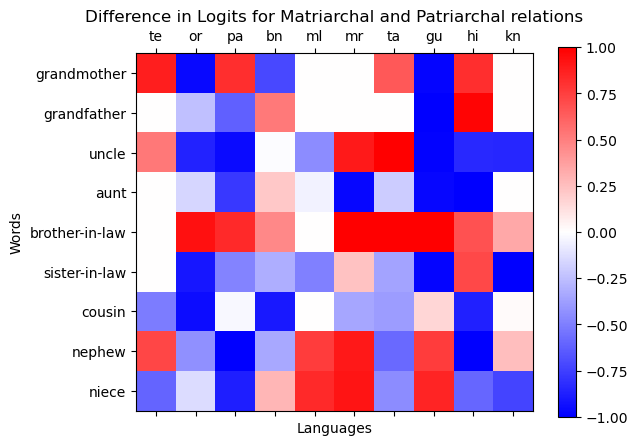

In [121]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# give colour custommed as max value as Pink and min value as blue and 0 as white
cax = ax.matshow(confusion_mat, cmap='bwr')
fig.colorbar(cax)

ax.set_xticks(range(len(final_res.keys()))) 
ax.set_xticklabels( list(lang_code_map[lang] for lang in final_res.keys()),  ha="center")
ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))
plt.xlabel('Languages')
plt.ylabel('Words')
plt.title('Difference in Logits for Matriarchal and Patriarchal relations')
# save the image to a file
fig.savefig('results/logit_prob_diff_'+str(SAMPLE_SIZE)+'.png')
plt.show()



In [94]:
# index of ['ମାମୁଁ', 'ମଉସା'] in vocab of en_indic_tokenizer
# print(en_indic_tokenizer.convert_tokens_to_ids(['ମାମୁଁ', 'ମଉସା'])) #[3, 3] - wrong

# print(en_indic_tokenizer.vocab



In [95]:
# # import the test_sentences_eng.txt file data as sents

# # sents = ['The river is blue.', 'My uncle wearing blue coat.', 'My maternal aunt went to the river bank.', "The doctor went to bank for money."]
# sents=['My maternal aunt went to the river bank.', 'My maternal aunt loves me.', 
#        'My maternal aunt loves her grandchildren.', "My maternal aunt loves her children.", 
#        "My maternal aunt loves her family.",
#        ]   
# src_lang = "eng_Latn"

# tgt_lang = 'hin_Deva'
# # print(lang)
# translations, logits = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind)


In [96]:
# print(translations)

['ನನ್ನ ಅಜ್ಜಿ ಬ್ರಾಹ್ಮಣರು. ', 'ನನ್ನ ಅಜ್ಜ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಚಿಕ್ಕಪ್ಪ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಚಿಕ್ಕಮ್ಮ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣೆ. ', 'ನನ್ನ ಅಳಿಯ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಅತ್ತಿಗೆ ಬ್ರಾಹ್ಮಣಳು. ', 'ನನ್ನ ಸೋದರಸಂಬಂಧಿ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ. ', 'ನನ್ನ ಸೋದರಳಿಯ ಬ್ರಾಹ್ಮಣನಾಗಿದ್ದಾನೆ. ', 'ನನ್ನ ಸೋದರ ಸೊಸೆ ಬ್ರಾಹ್ಮಣಳು. ', 'ನನ್ನ ಅಜ್ಜಿ ಒಬ್ಬ ಕ್ಷತ್ರಿಯ. ']


In [97]:
# print(logits)

tensor([-0.8970, -0.8960, -1.3037,  ..., -0.8960, -0.8965, -0.8965],
       dtype=torch.float16)


Verify for Odia that logits at correct positions have been extracted

In [98]:
# for each logit in logits, convert it to prob using softmax
for lang in lang_script_list:
    if lang != 'ory_Orya':
        continue
    logits = output_logits[lang]
    softmax_logits = [softmax(logit, dim=-1) for logit in logits]
    print(softmax_logits)
    print(len(softmax_logits) ) # for each sentence translated)
    print(softmax_logits[0].shape) # for each word in the sentence; vocab size

# for each sentence, amongs all vocab logits, find the difference of [sum of matrirach words] - [sum of patriarch words]
# find the root word in english and as per lang, find the other Matriarch or Patriarch words based on relation code 

[tensor([3.5763e-07, 3.5763e-07, 5.9605e-08,  ..., 3.5763e-07, 3.5763e-07,
        3.5763e-07], dtype=torch.float16), tensor([4.1723e-07, 4.1723e-07, 1.1921e-07,  ..., 4.1723e-07, 4.1723e-07,
        4.1723e-07], dtype=torch.float16), tensor([9.5367e-07, 9.5367e-07, 6.5565e-07,  ..., 9.5367e-07, 9.5367e-07,
        9.5367e-07], dtype=torch.float16), tensor([1.0133e-06, 1.0133e-06, 4.1723e-07,  ..., 1.0133e-06, 1.0133e-06,
        1.0133e-06], dtype=torch.float16), tensor([5.3644e-07, 5.3644e-07, 1.1921e-07,  ..., 5.3644e-07, 5.3644e-07,
        5.3644e-07], dtype=torch.float16), tensor([7.1526e-07, 7.1526e-07, 2.3842e-07,  ..., 7.1526e-07, 7.1526e-07,
        7.1526e-07], dtype=torch.float16), tensor([1.0133e-06, 1.0133e-06, 2.9802e-07,  ..., 1.0133e-06, 1.0133e-06,
        1.0133e-06], dtype=torch.float16), tensor([3.5763e-07, 3.5763e-07, 1.7881e-07,  ..., 3.5763e-07, 3.5763e-07,
        3.5763e-07], dtype=torch.float16), tensor([9.5367e-07, 9.5367e-07, 2.3842e-07,  ..., 9.5367e-07, 9

In [99]:
# get the index of max prob for each logit
max_prob_index = [torch.argmax(softmax_logit, dim=-1) for softmax_logit in softmax_logits]
print(max_prob_index)

[tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(60824), tensor(4300), tensor(980), tensor(41445)]


In [100]:
# from the softmax_logits, get the indices of top 10 max prob 
top_10_indices = [torch.topk(softmax_logit, k=10, dim=-1) for softmax_logit in softmax_logits]
print(top_10_indices)

[torch.return_types.topk(
values=tensor([0.8823, 0.0048, 0.0035, 0.0031, 0.0028, 0.0021, 0.0021, 0.0016, 0.0016,
        0.0014], dtype=torch.float16),
indices=tensor([41445,    80,    30,  8911, 51174, 29498, 33622, 48446, 30261, 30502])), torch.return_types.topk(
values=tensor([0.8306, 0.0312, 0.0203, 0.0101, 0.0087, 0.0076, 0.0056, 0.0024, 0.0017,
        0.0010], dtype=torch.float16),
indices=tensor([41445, 53208, 15588, 20077, 30502,    30,   409,  1111, 55513, 51174])), torch.return_types.topk(
values=tensor([0.5093, 0.1919, 0.0316, 0.0116, 0.0104, 0.0051, 0.0042, 0.0039, 0.0035,
        0.0035], dtype=torch.float16),
indices=tensor([ 9971, 41565, 24501,    30, 41445,  7610, 20077,  3991,  3617, 15588])), torch.return_types.topk(
values=tensor([0.6060, 0.0270, 0.0156, 0.0095, 0.0076, 0.0057, 0.0052, 0.0051, 0.0051,
        0.0049], dtype=torch.float16),
indices=tensor([30261, 41445,  9971,    30,  3617,   213, 54203,   336, 58401,  1390])), torch.return_types.topk(
values=tensor(

In [101]:
# from the top_10_indices, get the words in Hindi vocab using tokenizer.target_tokenizer
word_list = []
for i in top_10_indices:
    with en_indic_tokenizer.as_target_tokenizer():
        word_list.append(en_indic_tokenizer.batch_decode(i.indices))
print(word_list)

[['जेजे ', 'न ', "' ", 'नानी ', 'नाति ', 'दादी ', 'माआ ', 'दिदि ', 'माउ ', 'पिताम '], ['जेजे ', 'पितामह ', 'दादा ', 'बापा ', 'पिताम ', "' ", 'द ', 'बड़ ', 'बापाङ्क ', 'नाति '], ['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'बापा ', 'भाइ ', 'खु ', 'दादा '], ['माउ ', 'जेजे ', 'माम ', "' ", 'खु ', 'अ ', 'माङ्क ', 'ब ', 'कुनि ', 'बो '], ['भि ', 'श् ', 'भा ', 'ज् ', 'भ ', 'श ', 'बो ', 'सा ', 'भाइ ', 'भाइर '], ['भा ', 'भि ', 'श् ', 'बो ', 'भउणी ', 'झ ', 'ज् ', 'श ', 'भ ', 'शा '], ['सम्पर्कीय़ ', 'भाइ ', 'माम ', 'भ्रातृ ', 'सम्प ', 'भउणी ', 'जणे ', 'बड़ ', 'भ्र ', 'क '], ['पुत ', 'भण ', 'भ ', 'भाइ ', "' ", 'पु ', 'भ्र ', 'भा ', 'सान ', 'सम्पर्कीय़ '], ['भ ', 'भण ', 'पुत ', 'झ ', 'भा ', 'भउणी ', 'भग ', 'भाइ ', 'बो ', 'जणे '], ['जेजे ', 'न ', 'नानी ', "' ", 'दादी ', 'नाति ', 'दिदि ', 'माआ ', 'आइ ', 'मात ']]


/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [102]:
for _ in word_list:
    print(_)

['जेजे ', 'न ', "' ", 'नानी ', 'नाति ', 'दादी ', 'माआ ', 'दिदि ', 'माउ ', 'पिताम ']
['जेजे ', 'पितामह ', 'दादा ', 'बापा ', 'पिताम ', "' ", 'द ', 'बड़ ', 'बापाङ्क ', 'नाति ']
['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'बापा ', 'भाइ ', 'खु ', 'दादा ']
['माउ ', 'जेजे ', 'माम ', "' ", 'खु ', 'अ ', 'माङ्क ', 'ब ', 'कुनि ', 'बो ']
['भि ', 'श् ', 'भा ', 'ज् ', 'भ ', 'श ', 'बो ', 'सा ', 'भाइ ', 'भाइर ']
['भा ', 'भि ', 'श् ', 'बो ', 'भउणी ', 'झ ', 'ज् ', 'श ', 'भ ', 'शा ']
['सम्पर्कीय़ ', 'भाइ ', 'माम ', 'भ्रातृ ', 'सम्प ', 'भउणी ', 'जणे ', 'बड़ ', 'भ्र ', 'क ']
['पुत ', 'भण ', 'भ ', 'भाइ ', "' ", 'पु ', 'भ्र ', 'भा ', 'सान ', 'सम्पर्कीय़ ']
['भ ', 'भण ', 'पुत ', 'झ ', 'भा ', 'भउणी ', 'भग ', 'भाइ ', 'बो ', 'जणे ']
['जेजे ', 'न ', 'नानी ', "' ", 'दादी ', 'नाति ', 'दिदि ', 'माआ ', 'आइ ', 'मात ']


# CONCLUSION

Found logits for ambiguos english words just before translating